# Modeling Crop Yield
## Python modules

In [1]:
import warnings
import time
import os

import dask
from dask.distributed import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Parameters
#### Choose a satellite.

For a description of the Landsat 8 mission, see the US Geological metadata [here.]()

For a description of the Sentinel 2 mission, see the US Geological metadata [here.]()

In [2]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2-l2a"

#### Choose band combination.

For a description of **Landsat** bands, see the [US Geological Survey documentation here.](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

For a description of **Sentinel bands**, see the [US Geological Survey documentation here.](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2#:~:text=4%20bands%20at%2010%20meter,%2Dinfrared%20(842%20nm)

According to our results, bands **(insert band selection here)** result in the best model performance for Landsat, and **(insert band selection here)** result in the best model performance for Sentinel for the task of predicting maize yields in Zambia.

In [3]:
#bands = "2-3-4"
bands = "2-3-4-8"
# bands = "1-2-3-4-5-6-7"
# bands = "2-3-4-5-6-7-8-11-12"

#### Choose the number of points that were featurized.

Each value in the following chunk represents the amount of thousands of points that were featurized in each respective feature file. These points represent a uniform subset of the spatial grid of Zambia. Points are spaced at uniform intervals for each selection, measured in kilometers in the longitudinal direction for each set of features. The kilometer distance interval differs for each selection below; 42,000 points results in the smallest uniform distance between points, and 4,000 points results in the greatest uniform distance between points. Selecting a greater quantity of points results in a denser spatial sample, which increases computational cost and time, but increases the spatial resolution of the model. Regardless of the quantity of points selected, each point is buffered by the same distance, resulting in a 1km^2 cell around each point.

These specific options point quantities is a result of uniformly increasing the distance between points in units of kilometers prior to matching satellite images to each point. These options represent the number of points that fall within the borders of Zambia, and the numbers have been rounded to the nearest thousandth for consistency in naming files. See the [CropMOSAIKS Featurization repository](https://github.com/cropmosaiks/Featurization) for more information regarding how these distances we calculated. 

In [4]:
points = 15
# points = 20

#### Choose to keep only areas with crops (`True`) or to keep all points (`False`)

Selecting `True` applies a "cropland mask" to the spatial grid of Zambia. This retains only the regions of the country in which maize is  grown, according to the **(insert source here)**. As a result, the spatial extent of the features that are fed into the model are highly subset for the specific task at hand: modeling maize yields. According to our results, selecting `True` **(insert increases or decreases here)** model performance.

Selecting `False` results in modeling with the maximum spatial extent of the features, with more generalized features as a result.

In [5]:
crop_mask = True
#crop_mask = False

Choose a weighted average (`True`) or a simple mean (`False`) to use when collapsing features to administrative boundary level.

In [6]:
#weighted_avg = True
weighted_avg = False

#### Choose which months to use in the model.

Note that months 10, 11, and 12 get pushed to the next year because the growing season (November - May) spans the calendar year. Maize is planted in November, starts to change color with maturity in May, and is harvested in June - August. According to our results, subsetting the months to **(insert month selection here)** increases model performance.

In [7]:
month_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# month_range = [      3, 4, 5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8, 9            ]
# month_range = [            5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8               ]
# month_range = [            5, 6, 7, 8               ]

#### Impute NA values by descending group levels (True) or `scikit learn`'s simple imputer (False)

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [8]:
#impute_manual = True
impute_manual = False

### Unchanging parameters

The parameters in the following chunk are set for the country of Zambia for with 1000 features, regardless of the satellite selected. The start years for each satellite reflect the respective years that Landsat 8 and Sentinel 2A missions began.

The number of features is set to 1000 to serve as a staple parameter among the several other parameters varied during the model optimization process. Changing this parameter in the following code chunk will result in an error because featurizing landsat imagery for a different number of features was outside the scope of this project.

In [9]:
country_code = "ZMB"
num_features = 1000

if satellite == "landsat-8-c2-l2":
    year_start = 2013 # Landsat
else:
    year_start = 2015 # Sentinel
year_end = 2021

taylor_data_dir = "/capstone/cropmosaiks/data"  
feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')
weight_file_name = (f'{country_code}_crop_weights_{points}k-points')

if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 15
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Administrative boundaries 

Administrative boundaries reflect the **(insert number of districts in dataset)** district boundaries within the country of Zambia. A district can be likened to a state within the larger U.S.A. We subset the spatial grid to district level becuase the crop yield data is at the district level of specificity. The features are originally produced at higher spatial resolution, then summarized to the district level in order to train the model with ground-truth crop data. 

<AxesSubplot:>

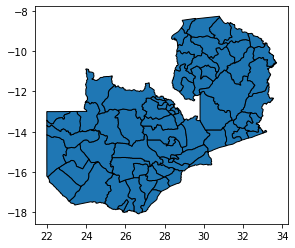

In [10]:
country_shp = geopandas.read_file(f'{taylor_data_dir}/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
country_shp.plot(linewidth = 1, edgecolor = 'black' )
# country_shp.plot()

## Crop yield

Zambian maize yield data reflects the predicted annual maize yield provided by farmers in the month of May, when the maize matures and changes colors prior to harvest, which allows the farmers to estimate what their yield will be in the following months. These predictions are in units of metric tons per hectare and provide valuable insight to the Zambian government as they plan for the quanitites of food to import into the country in the future. For more metadata, see the websites for the [Central Statistics Office of Zambia (CSO)](https://www.zamstats.gov.zm/) and the [Summary statistics from CSO.](https://www.zamstats.gov.zm/agriculture-environment-statistics/)

In order to standardize the names of all districts shared between the geoboundaries and the crop yield data, we correct for spelling, dashes, and apostrophes. 


In [11]:
crop_df = pd.read_csv(taylor_data_dir+'/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
# crop_df

74

In [12]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [13]:
list(set(country_districts) - set(crop_districts))

[]

In [14]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Crop land

In [15]:
weights = pd.read_feather(f"{taylor_data_dir}/weights/{weight_file_name}.feather")
# weights

<AxesSubplot:>

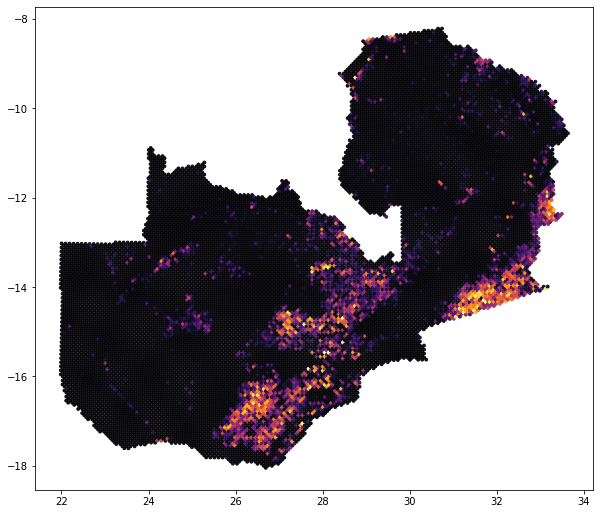

In [16]:
weights_gdf = geopandas.GeoDataFrame(
    weights, 
    geometry = geopandas.points_from_xy(x = weights.lon, y = weights.lat), 
    crs='EPSG:4326'
)
weights_gdf.plot(figsize = (10,10),
                 cmap = 'inferno',
                 markersize = marker_sz,
                 alpha = .9,
                 column = 'crop_perc')
# plt.axis('off')

In [17]:
weights.crop_perc = weights.crop_perc.fillna(0)
# #weights.crop_perc = weights.crop_perc + 0.0001

## Features

Append annual features files together into one file: `features_raw`.

In [18]:
features_raw = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"{taylor_data_dir}/features/{satellite}/{feature_file_name}_{yr}.feather")
    
    if (yr == 2013) & (satellite == "landsat-8-c2-l2"):
        features_x = features_x[features_x.month > 9]
    elif (yr == 2015) & (satellite == "sentinel-2-l2a"):
        features_x = features_x[features_x.month > 9]
    else:
        pass
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_raw = pd.concat([features_raw, features_x], axis=0)
    
    print("feature.shape", features_raw.shape)
    print("Appending:", yr)
    print("")

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2015.feather
feature.shape (9641, 1004)
Appending: 2015

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2016.feather
feature.shape (145645, 1004)
Appending: 2016

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2017.feather
feature.shape (262443, 1004)
Appending: 2017

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2018.feather
feature.shape (411433, 1004)
Appending: 2018

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2019.feather
feature.shape (565985, 1004)
Appending: 2019

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2020.feather
feature.shape (699975, 1004)
Appending: 2020

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2021.feather
feature.shape (841959, 1004)
Appending: 2021



In [19]:
# make a copy of the raw features before we convert growing season months at the end of the year to the next year, summarise to district level, and other processing so we can plot raw features later at feature-level resolution
features = features_raw.copy()

In [20]:
# carry months October, November, and December over to the following year's data
# these months represent the start of the growing season for the following year's maize yield
features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

### Filter month range

In [21]:
# subset the features to only the month range selected at the top of the notebook
features = features[features.month.isin(month_range)]

### Pivot wider
Here we pivot the data from long format to wide by indexing on 'lon', 'lat', 'year', 'month' and using the unstack function. We then map column names based on the month index and the associated features so month '01' is appended to each feature for that month making 0_01, 1_01 etc. This results in a Tidy data structure, with each row representing an image, and each column representing a feature for a certain month.

In [22]:
features = features.set_index(['lon','lat', "year", 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

KeyboardInterrupt: 

### Replace "inf" values with `NaN`

Infinity values are the result of **(insert reason here)**. We replace them with `NaN` because **(insert reason here)**.

In [ ]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.reset_index()
# features

### Attach crop weights
Attach weight to each point (% area cropped of surrounding 1 km^2).

In [ ]:
features = features.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
features = features.drop(["geometry"], axis = 1)
# features

### Mask croppped regions

In [ ]:
# any 1 km^2 cell with a crop percentage > 0 will be retained
# the mask will not be applied if crop_mask is set to False at the top of this notebook
if crop_mask:
    features = features[features.crop_perc > 0]
else:
    pass
# features

### Make "features" a `GeoDataFrame`

The coordinate reference system is set to EPSG 4326 - WGS 84, the latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System.

In [ ]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
    crs='EPSG:4326'
)

### Plot any single feature

In [ ]:
# mn = 9
# yr = 2017
# feature = 999

# features[features.year == yr].plot(
#     column = f"{feature}_{mn}",
#     figsize = (10,10),
#     marker='H',
#     # legend = True,
#     markersize = marker_sz,
# )

### Drop 'lat' and 'lon' columns

In [ ]:
# Drop the redundant independent lon and lat columns because now that they are in a separate geometry column, there is no need for these columns
features = features.drop(['lon', 'lat'], axis = 1)

### Join features to country geometry

Join the partially processed feature data to Zambia geometry to join to district level (the highest resolution at which we have maize yield data). After imputation and some minor data porcessing steps, the features will be summarized to each district level. Although this lowers spatial resolution of the features, it is a necessary step to train the model because the district-level crop yields need to be paired with the district-level features in order to execute supervised machine learning.

In [ ]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')
features

In [ ]:
# na = features[adm_features.isna().any(axis = 1)]
# na.plot(figsize = (10,10), markersize = 10)

### Correct column names and drop geometry

In [ ]:
# Drop NA's from the district column (called index_right) then rename the column index_right to district
features = (
    features
    # drop NA values in the `index_right` column, then rename that column to `district` for clarity
    .dropna(subset=['index_right'])
    .rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
# make a copy of the features, assigned to an object so we can plot the points as they are in this state
# later, after imputation, we also copy the entire features df and save that as an object in case we want to plot or work with them in that stage 
points = features.copy()
# save the geometries as an object to join them later to the rows of crop yield predictions
points = features[['geometry']]
# save the years as an object to join them later to the rows
year = features[['year']]
# drop geometry column for 20/21 features
features = features.drop(['geometry'], axis = 1)
features

### Intermediate Processing Check: Plot the Features

So far, the features have been masked to just the crop regions of Zambia. Therefore, we expect the plotted points to roughly show the border of Zambia and be present throughout the country, with certain chunks of points missing in areas where crops are not grown. This serves as a "sanity check" that we are on-track with our spatial processing. 

In [ ]:
points.plot()

### Impute missing values

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

The imputation approach depends on the selection made at the top of this notebook for `impute_manual`.

In [ ]:
# compute the number of cells in the features dataframe, based on the amount of rows (images), months, and feature columns
num_cells = len(features) * len(month_range) * num_features

In [ ]:
# import dask.dataframe as dd

In [ ]:
# dfeatures = dd.from_pandas(features, npartitions=1)

In [ ]:
# %%time
# if impute_manual:
#     with Client(n_workers=16) as client:
        
#         print(f'Total rows: {(len(dfeatures))} \nPre-Impute NaN row count: {(len(dfeatures) - len(dfeatures.dropna()))} ',
#               f'\nPre-Impute NaN row %: {((len(dfeatures) - len(dfeatures.dropna())) / len(dfeatures))*100:.02f}',
#               f'\nPre-Impute NaN cell %: {(dfeatures.isna().sum().sum() / num_cells)*100:.02f}')

#         print(f'\nStep 1: Filling NaN values by month, year, and district group average')
#         dfeatures = (
#             dfeatures
#             .fillna(dfeatures
#                     .groupby(['year', 'district'], as_index=False)
#                     .transform('mean')
#                    )
#                 #.compute()
#         )
#         print(f'{(dfeatures.isna().sum().sum() / num_cells)*100:.02f} % NaN cell values after imputing step 1')

#         print(f'\nStep 2: Filling NaN values by month and district across group average')
#         dfeatures = (
#             dfeatures
#             .fillna(dfeatures
#                     .groupby(['district'], as_index=False)
#                     .transform('mean')
#                    )
# #                 .compute()
#         )
#         print(f'{(dfeatures.isna().sum().sum() / num_cells)*100:.02f} % NaN cell values after imputing step 2')

#         print('\nStep 3: Drop remaining NaN values')

#         print(f'Total rows: {(len(dfeatures))} \nPost-Impute NaN row count: ',
#               f'{(len(dfeatures) - len(dfeatures.dropna()))} \nPost-Impute NaN row %: ',
#               f'{((len(dfeatures) - len(dfeatures.dropna())) / len(dfeatures))*100:.02f}\n', sep = "")
#         dfeatures = dfeatures.dropna(axis=1)
#     #         .compute()
#         print(f'{(dfeatures.isna().sum().sum() / num_cells)*100:.02f} % NaN cell values\n')
# else:
#     dfeatures = dfeatures.set_index(['year', 'district'])
#     imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#     imputer.fit_transform(dfeatures)
#     dfeatures[:] = imputer.transform(dfeatures)
#     dfeatures = dfeatures.reset_index()

In [ ]:
class bcolors:
    BL = '\x1b[1;34m' #GREEN
    GR = '\x1b[1;36m' #GREEN
    YL = '\x1b[1;33m' #YELLOW
    RD = '\x1b[1;31m' #RED
    RESET = '\033[0m' #RESET COLOR

In [ ]:
%%time
if impute_manual:
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Starting total row count: {bcolors.BL}{ln_ft}{bcolors.RESET}',
          f'\nPre-Impute NaN row count: {bcolors.RD}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPre-Impute NaN row %: {bcolors.RD}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPre-Impute NaN cell %: {bcolors.RD}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 1: Filling NaN values by month, year, and district group average')
    features = (
        features
        .fillna(features
                .groupby(['year', 'district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 1 NaN row count: {bcolors.YL}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 1 NaN row %: {bcolors.YL}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 1 NaN cell %: {bcolors.YL}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 2: Filling NaN values by month and district across group average')
    features = (
        features
        .fillna(features
                .groupby(['district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 2 NaN row count: {bcolors.GR}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 2 NaN row %: {bcolors.GR}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 2 NaN cell %: {bcolors.GR}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 3: Drop remaining NaN values\n')
    features = features.dropna(axis=0)
    print(f'Ending total row count: {bcolors.BL}{len(features)}{bcolors.RESET}')
else:
    features = features.set_index(['year', 'district'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()

### Save copy of completed data

Duplicate the features dataframe so we can summarize features to district resolution for one set and still retain features at point resolution in other dataframe. Now that the `NA` values have been imputed or dropped, we might choose to plot these features for all years together _and_ we will feed this dataframe into the model (after it has been trained) in order to generate predictions for all years and demonstrate the overall performance. In this copy etap, ee preserve all features as they have undergone all processing besides the processing that will only be executed on the 2014-2018 features in order to prepare them for model training. The copy is called `features_copy` and the features that will be split and processed futher is called `features`.

In [ ]:
features_copy = features.copy()

# assign the geometry col to features_copy so it can serve 2 purposes: 1. plotting and 2. the entire df can be fed into the model after it is trained on only the features for 2014-2018 and the associated crop data
features_copy['geometry'] = points.geometry
# moving forward, use `features` to summarize to district level (we dont need geoometries for that since `district` is already present in this df as a column)

### Split features into `2014-2018` and `2019-2021`

All feature data required the processing steps executed above. However, the following code is not executed on _all_ features.\
1. The `2014-2018` (Landsat 8) or `2015-2018` (Sentinel 2) set of features will be summarized to administrative boundary level (all rows (points) have already been assigned to the district in which they reside).
2. These summarized features for `2014-2018` (Landsat 8) or `2015-2018` (Sentinel 2) will then be joined with the district-resolution crop data. Next, we split these features into train and test sets, and then use them to train the model using ridge regression.
3. We will then apply the trained model to the large, comprehensive feature set for `2014-2021` (Landsat) or `2015-2021` (Sentinel), which includes all years regardless if those years have ground truth crop data. 

We are most interested in the crop predictions for the three years 2019-2021 because the model was not trained on these years. Therefore, we split the data here to execute different analysis moving forward. The feature data for `2019-2021` is called `features_without_crop_data` to be explicit about its context. The following code splits the data correctly no matter which satellite was selected at the top of the notebook.

**Note:** After we train the model, if we are interested in running the model on ALL feature years `2014-2021`, rather than just the years without crop data, then we would feed in the features dataframe we copied in the section prior, called `features_copy`. If instead we are only interested in modeling for `2019-2021`, then we would later feed in the dataframe `features_without_crop_data`.

In [ ]:
# separate the data into 2 groups: 2014/2015-2018 for model training and 2014/2015-2021 for predicting on all years
features_model_training = features[features.year <= 2018]

# check that subsetting years worked
features_model_training["year"].unique()
# should be 2016, 2017, 2018 for Sentinel
# should be 2013, 2014, 2015, 2016, 2017, 2018 for Landsat

In [ ]:
features_without_crop_data = features[features.year >= 2019]

# check that subsetting years worked
features_without_crop_data["year"].unique()
# should be 2019, 2020, 2021 regardless if the satellite is Sentinel or Landsat

### Summarise to administrative boundary level
Weighted by cropped area, or simple mean, depending on the selection at the top of this notebook for `weighted_avg`. 

In [ ]:
# check columns in the dataframe that will be fed into the ridge regression in order to train the model
# we care about the order of columns specifically because in the following steps we assign only the feature columns to an object, so we need to know which 3 columns to omit by indexing
features_model_training.columns

In [ ]:
# check the shape to the dataframe as a sanity check
features_model_training.shape

In [ ]:
# create object that contains only feature columns, rather than all columns that would include `district`, `year`, and `crop_perc`
# python index starts at 0, so here we specify to retain columns starting at 3 through every column besides the last
# the columns we omit stay in the dataframe, becuase we assign the selected columns to an object, but the omitted columns are not included in the calculation in the next chunk
var_cols = features_model_training.columns[2:-1].values.tolist()
# call the object `var_cols` to check that it only includes feature columsn, but do not view it in list format because it is more readable not as a list 
features_model_training.columns[2:-1]
# these are all the feature columns that will be fed into the weighted_avg calculation 

In [ ]:
%%time
# finally, execute the weighted average on the cropped area! This gives more weight (importance) to area in Zambia that has a high proportion of cropland
# this differs from the masking step that was executed earlier, because the masking step completely removed all land that was 0% cropland, and this step processes the land that is at least 1% cropland
if weighted_avg:
    features_summary = (
        features_model_training
        .groupby(['year', 'district'], as_index=False)
        .apply(lambda x: pd.Series([sum(x[v] * x.crop_perc) / sum(x.crop_perc) for v in var_cols]))
    )
# if weighted_avg was set to FALSE at the beginning of the notebook, the weighted avergae is not executed
# instead, the features are simply summarized by district and year, which also occurred above if weighted_avg was set to TRUE
else:
    features_summary = features_model_training.groupby(['district',"year"], as_index = False).mean()
# now that we have renamed our features object to `features_summary`, note that we use this object moving forward

Now that the features have been summarized to district and year, there are fewer rows. The dataframe we were working with before this step,  `features_model_training`, had 13866 rows that represented points. Now we have 216 rows: 

In [ ]:
features_summary.shape

### Join crop data

Combine the crop data and features into 1 dataframe in order to train the model on this object in the next section.

In [ ]:
# recall the object `crop_df` from much earlier in the notebook 
crop_df_x = crop_df[crop_df.year >= year_start + 1]
crop_df_x = crop_df_x[~crop_df_x.index.isin(['Mafinga', 'Ikelenge'])]
crop_df_x.reset_index(inplace=True)
# take a look at the crop dataframe as a sanity check that the processing steps were correct
# the `yield_mt` data is in units of metric tonnes per hectare of cropland planted
crop_df_x
# if interested, please see more details about the crop data in our technical documentation for this project

In [ ]:
features_summary = (
    features_summary
    .set_index(["district", "year"])
    .join(other = crop_df_x.set_index(["district", "year"]))
    .reset_index())

features_summary.columns
# now that the data is joined, the column `yield_mt` is present in `features_summary`

## Model

In [ ]:
# create a new object that 
#model_year = features_summary[features_summary.year.isin([
#   2014,
#   2015,
#   2016,
#   2017,
#   2018,
#])]

### Define `x's` and `y's` that will be a part of training the model

In [ ]:
# this if-else statement is determined by the selection of True or False made at the top of the notebook for the object `weigthed_avg`
if weighted_avg:
    drop_cols = ['district', 'year', 'yield_mt']
else:
# if the selection was False, we can drop the `crop_perc` columns because we will not use it moving forward
    drop_cols = ['district', 'year', 'yield_mt', "crop_perc"]
# note that this chunk does not actually execute the column dropping, it just defines the object that will determine which are dropped in the next chunk

In [ ]:
# define ALL x's (the features_summary data that will be fed into the model to train) by dropping the columns specified in the previous chunk
# if the axis argument was set to 0, this code would incorrectly drop rows instead of columns
x_all = features_summary.drop(drop_cols, axis = 1)

# log transform the yield_mt column because that was recommended by the client
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [ ]:
# take a look at the first 10 values of the log transformed `yield_mt` array to get an idea of the scale of the crop yields we use to train the model
print(y_all[:10])

### Split into train and test sets

This step is executed right before training the model so we can train on 80% of the data and preserve 20% for testing.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [ ]:
print("Number of total points: ", len(x_all), "\n", 
      "Number of training points: ", len(x_train), "\n",
      "Number of testing points: ", len(x_test), sep = "")

### Train model using ridge regression

Please see the documentation for the function that executes this regression [here.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

In [ ]:
# sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
# cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
# ridge_cv_random = RidgeCV(cv=cv, alphas=[0.001, 0.01, 1, 10])
# ridge_cv_random = RidgeCV(cv=cv, alphas=np.logspace(-8, 8, base=10, num=17))
# ridge_cv_random = RidgeCV(
#     cv=5, 
#     alphas=np.logspace(-5, 5, base=10, num=11),
#     scoring='r2',
#     scoring='max_error',
#     scoring='explained_variance'
# )
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

In [ ]:
print(f"Estimated regularization parameter {ridge_cv_random.alpha_}")

### Validation set $R^2$ performance

In [ ]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

### Train set

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

fig, ax = plt.subplots(ncols=1)
# fig, ax = plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axline([0, 0], [1, 1])
m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)


# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()
# the model is plotted with a black trendline and a blue 45 degree line that serves as a reference of what a perfect correlation would look like
# deviation of the lines indicates that there is not a perfect correlation

In [ ]:
print(f"Training R^2 = {r2_score(y_train, y_pred):0.2f}\nPearsons r = {pearsonr(y_pred, y_train)[0]:0.2f}") 

In [ ]:
pearsonr(y_pred, y_train)[0]  ** 2

In [ ]:
ridge_cv_random.score(x_train, y_train)

### Test set

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [ ]:
print(f"Testing set R^2 = {r2_score(y_test, y_pred):0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

### Plot the fitted features

# add to this markdown chunk to explain what is happening in this section

In [ ]:
# recall the object we created earlier, before we split the features by year into those that would train the model and those that would be fed into the trained model to predict crop yields in years for which we do not have crop data
#features_copy

In [ ]:
# copy this copy and rename it meaningfully
# this makes it easier to change the following code chunks & start over with modifications if you made an error when fitting, etc. without needing to rerun the entire notebook to reset important object
features_for_2014_2021_predictions = features_copy.copy()

In [ ]:
#x_all = features_for_predictions.drop([
#    'year', 
#    'geometry',
#    'district',
#    'crop_perc'
#], axis = 1)
#features_for_predictions['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [ ]:
#features_for_predictions = geopandas.GeoDataFrame(features_for_predictions)

In [ ]:
#features_for_predictions['fit'].mask(features_for_predictions['crop_perc']==0, 0, inplace=True)
# pred_features.loc[pred_features["crop_perc"] == 0, "fit"] = 0   ### Does same thing but differently

In [ ]:
# pred_features = pred_features[pred_features.crop_perc > 0].reset_index(drop = True)

In [ ]:
#features_for_predictions['fit'].mask(features_for_predictions['fit'] > 2, 0, inplace=True)

In [ ]:
#features_for_predictions = features_for_predictions[features_for_predictions.year == 2018]

In [ ]:
#features_for_predictions.plot(figsize = (10,10),
#                   marker='H',
#                   legend = True,
#                   markersize = marker_sz,
#                    alpha = .9,
#                   column = 'fit')

### Run trained model on features for 2019 - 2021

The features we plug into the model here, `features_for_predictions` represents the years not summarized to administrative boundary level or joined to the crop data, `2019-2021`. Recall that we only have crop data available for Zambia for `2016-2018`, which is why the features for those years are what we used to train the model. 

In [ ]:
# remind yourself of the shape of this dataframe
features_without_crop_data.shape

In [ ]:
# remind yourself of the columns in this dataframe
features_without_crop_data.columns

In [ ]:
# before we remove several columns in the next step, save the `district` and `year` columns as separate objects that will then be re-joined to the predictions that result from the features
districts = features_without_crop_data['district']
years = features_without_crop_data['year']

In [ ]:
# check out the districts object we just created
districts.unique()

In [ ]:
# check out the year object we just created
years.unique()

In [ ]:
features_without_crop_data = features_without_crop_data.drop([
    'district', 
    'year', 
    "crop_perc"
], axis = 1) 

In [ ]:
# confirm that the only columns are all features
features_without_crop_data.columns

In [ ]:
# generate predictions for the features that were processed for this purpose
# need to execute the ridge_cv_random within the np.maximum() function because some predictions results are negative and we need them all to be positive because conceptually crop yields cannot be negative
pred_2019_2021 = np.maximum(ridge_cv_random.predict(features_without_crop_data), 0)
pred_2019_2021

In [ ]:
# intermediate check:
# confirm that the length of the array of predicitions is the same number of rows as the feature data fed into the model
length_predictions = len(pred_2019_2021)
length_features = len(features_without_crop_data)
# the next line will return True if they are the same length or False if not
length_predictions == length_features

In [ ]:
# convert the predictions from an array into a gdf so we can re-join the points and year variables to plot 
pred_2019_2021_gdf = geopandas.GeoDataFrame(pred_2019_2021)
pred_2019_2021_gdf

In [ ]:
# rename column for predictions just for clarity, this duplicates the column 0 so we need to drop in the next chunk
pred_2019_2021_gdf['pred_yields'] = pred_2019_2021_gdf[0]
pred_2019_2021_gdf

In [ ]:
# drop one duplicated column, the one with the non-descriptive name
pred_2019_2021_gdf = pred_2019_2021_gdf.drop([0], axis = 1)
pred_2019_2021_gdf
# recall that the units are metric tonnes per hectare

# ATTENTION: Before executing the next chunk we need to reassign the object `points` to those from the dataframe that is only years 2019-2021

In [ ]:
# first make a copy of the gdf but we will move forward with processing the original file
pred_2019_2021_gdf_copy = pred_2019_2021_gdf.copy()

# rejoin the points geometry and year columns so we can plot both years independently
# recall that we made this `points` objects directly from the `features` dataframe, which was the parent dataframe of the one fed into the model to produce the predictions that we are processing here
pred_2019_2021_gdf['geometry'] = points.geometry
pred_2019_2021_gdf['year'] = year
# check that the geometries were properly rejoined
pred_2019_2021_gdf

In [ ]:
# separate the data by year, we care most about 2019, 2020, and 2021 so these are the default years to subset the predictions df

#yr = 2014
#yr = 2015
#yr = 2016
#yr = 2017
yr = 2018
#yr = 2019
#yr = 2020
#yr = 2021

pred_yield = pred_14_21_gdf[pred_14_21_gdf.year == yr]

In [ ]:
pred_yield

In [ ]:
# plot 2019 crop predictions
pred_yield.plot(figsize= (15,15),
                  marker = 'H',
                  legend = True,
                  markersize = 20,
                  column = "pred_yields")

## Yield and Residual Plots
### Create data frame 

In [ ]:
x_all = features_summary.drop(drop_cols, axis = 1)

residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
#demean by location
residual_df["district_yield_mean"] = residual_df.groupby('district')['log_yield'].transform('mean')
residual_df["district_prediction_mean"] = residual_df.groupby('district')['prediction'].transform('mean')
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["district_yield_mean"]
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["district_prediction_mean"]
residual_gdf = geopandas.GeoDataFrame(residual_df)
# residual_gdf

### Crop yield histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "yield_mt", bins = 20)
g.set_axis_labels("Yield (MT)")

### Log transform crop yield histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "log_yield", bins = 20)
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

### Crop prediction histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "prediction", bins = 20)
g.set_axis_labels(r"Crop yield predictions")

### Residual histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "residual", bins = 20)
g.set_axis_labels(r"Residuals")

In [ ]:
residual_gdf.residual.min()

In [ ]:
residual_gdf.residual.max()

### Log rop yield vs residuals

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "log_yield", "residual")
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

### District residuals

In [ ]:
if satellite == 'landsat-8-c2-l2':
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    ax1 = (residual_gdf[residual_gdf.year == 2014]
           .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2014 Residuals"))
    ax2 = (residual_gdf[residual_gdf.year == 2015]
           .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2015 Residuals"))
else:
    pass
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

### Difference from the Mean

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "demean_yield", "demean_prediction")
g.set_axis_labels('Difference from Yield Mean', 'Difference from Prediction Mean')

In [ ]:
plt.scatter(residual_gdf.demean_yield, residual_gdf.demean_prediction)
plt.title("Demeaned truth and predictions by district")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')

In [ ]:
for yr in range(year_start+1, year_end+1):
    r_squared = r2_score(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    pearson_r = pearsonr(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    
    print(yr, f"    R^2: {r_squared:.2f}\n",
          f"Pearson's r: {pearson_r[0]:.2f}\n", 
          sep = "")
    
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
pearson_r = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print(f"All     R^2: {r_squared:.2f}\n",
      f"Pearson's r: {pearson_r[0]:.2f}", sep = "")

In [ ]:
round(pearson_r[0] ** 2, 2)